Redes neuronales convolucionales (CNN): Estos modelos son especialmente útiles para tareas de procesamiento de imágenes, como la clasificación y detección de objetos. Los modelos CNN, como AlexNet, VGGNet, ResNet, DenseNet, y más recientemente, EfficientNet, han demostrado un rendimiento excepcional en estas tareas.

Las CNN son especialmente buenas para el procesamiento de imágenes debido a su capacidad para manejar datos espaciales bidimensionales. En esencia, aprenderán "características" de las imágenes a través de convoluciones y luego utilizarán estas características para hacer predicciones.

Vamos a utilizar el conjunto de datos de Fashion MNIST. Este es un conjunto de datos que incluye 60.000 imágenes de entrenamiento de 28x28 píxeles en escala de grises, y 10.000 imágenes de prueba. Cada imagen es una prenda de vestir que pertenece a una de las 10 categorías siguientes: camiseta/top, pantalón, pullover, vestido, abrigo, sandalia, camisa, zapatilla de deporte, bolso y bota de tobillo.

In [1]:
# Importamos las librerías necesarias

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import tensorflow as tf

2023-06-09 00:04:10.205931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Cargamos los datos de entrenamiento y test

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Vemos la forma de los datos
print('Training data shape : ', train_images.shape, train_labels.shape)
print('Testing data shape : ', test_images.shape, test_labels.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


Para este conjunto de datos, el preprocesamiento será bastante sencillo: sólo necesitamos reescalar las imágenes para que los valores de los píxeles estén en el rango de 0 a 1, y luego remodelar los datos para que sean compatibles con el formato que Keras requiere para las redes convolucionales. También debemos convertir nuestras etiquetas a codificación one-hot.

In [3]:
# Normalizamos de las imagenes a valores entre 0 y 1

train_images = train_images / 255.0
test_images = test_images / 255.0

# Remodelamos los datos para que sean compatibles con las redes convolucionales.

# Transformar tus etiquetas a representación one-hot
num_classes = 10
train_labels = tf.one_hot(train_labels, num_classes)
test_labels = tf.one_hot(test_labels, num_classes)

Primero, normalizamos las imágenes dividiendo cada píxel por 255. Esto es porque las imágenes son en escala de grises y cada píxel tiene un valor entre 0 y 255. La normalización de estos valores a un rango de 0 a 1 hace que sea más fácil para nuestro modelo aprender.

A continuación, remodelamos las imágenes. Las redes convolucionales en Keras esperan los datos en un formato particular que incluye la altura y la anchura de la imagen, así como el número de canales de color (1 para las imágenes en escala de grises, 3 para las imágenes en color). Nuestras imágenes son de 28x28 píxeles y están en escala de grises, por lo que remodelamos los datos a (-1, 28, 28, 1).

Por último, convertimos las etiquetas a codificación one-hot. Nuestras etiquetas son números enteros entre 0 y 9, pero necesitamos que estén en formato de codificación one-hot para que sean compatibles con la función de pérdida que utilizaremos más adelante.

Creación de la Red Convolucional

Vamos a usar Keras para crear nuestra red. Vamos a crear una red bastante simple con dos capas convolucionales, seguidas de capas de max pooling, y finalmente una capa densa para la clasificación.

Las capas Conv2D aplican un conjunto de filtros a la imagen. Cada filtro es capaz de detectar una característica específica, como un borde en una dirección particular, un color, o una textura.

Las capas MaxPooling2D reducen el tamaño de la imagen al tomar el valor máximo de bloques de píxeles de un tamaño determinado. Esto ayuda a hacer el modelo más eficiente y también puede ayudar a prevenir el overfitting.

Las capas Flatten toman la salida de las capas convolucionales y la aplana a un vector, que puede ser alimentado a una capa densa.

Las capas Dense son simplemente una red neuronal completamente conectada. En nuestro caso, usamos una capa densa para la clasificación final de las imágenes en las diferentes clases de prendas de vestir.

In [4]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

La capa Conv2D toma varios argumentos: el número de filtros que la capa debe tener, el tamaño de los filtros, y la función de activación. Utilizamos la función de activación ReLU porque es una buena elección general para las redes neuronales.

La capa MaxPooling2D toma un argumento: el tamaño de la ventana de pooling. Elegimos una ventana de 2x2, lo que significa que la imagen se reduce a la mitad de su tamaño en cada dimensión.

La capa Dense toma dos argumentos: el número de neuronas en la capa, y la función de activación. La última capa utiliza una función de activación softmax porque estamos haciendo clasificación multiclase, y softmax nos da una distribución de probabilidad sobre las clases.

### Compilamos el modelo:

Una vez que hemos definido la arquitectura de nuestra red neuronal, necesitamos compilar el modelo. Durante la compilación, configuramos la función de pérdida, el optimizador y las métricas que queremos seguir durante el entrenamiento.

La función de pérdida es lo que el modelo intenta minimizar durante el entrenamiento, por lo que es fundamental elegir una que sea apropiada para nuestro problema de clasificación multiclase. Vamos a utilizar 'sparse_categorical_crossentropy', que es una buena opción para problemas de clasificación multiclase donde las etiquetas son números enteros.

Para el optimizador, vamos a usar 'adam'. Adam es un optimizador de gradiente descendente basado en la estimación adaptativa de momentos de primer y segundo orden. Se ha demostrado que funciona bien en la práctica y es bastante robusto a la elección de los hiperparámetros iniciales.

Finalmente, vamos a seguir la métrica de 'accuracy' durante el entrenamiento, que nos da una buena indicación de cómo va el entrenamiento.

In [5]:
# Compilamos el modelo

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [6]:
# Entrenamos el modelo

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10


/Users/adrianinfantesromero/opt/anaconda3/lib/python3.9/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 [==============================] - 15s 8ms/step - loss: 0.4652 - accuracy: 0.8311 - val_loss: 0.3638 - val_accuracy: 0.8672
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3090 - accuracy: 0.8885 - val_loss: 0.3161 - val_accuracy: 0.8855
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2668 - accuracy: 0.9017 - val_loss: 0.2802 - val_accuracy: 0.8987
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2357 - accuracy: 0.9132 - val_loss: 0.2751 - val_accuracy: 0.8978
Epoch 5/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.2108 - accuracy: 0.9222 - val_loss: 0.2681 - val_accuracy: 0.9047
Epoch 6/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.1902 - accuracy: 0.9288 - val_loss: 0.2591 - val_accuracy: 0.9040
Epoch 7/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.1716 - accuracy: 0.9358 - val_loss: 0.2789 - val_accuracy: 0.8

Para entrenar el modelo llamamos a model.fit, pasando los datos de entrenamiento, el número de épocas que queremos entrenar, y los datos de validación. El entrenamiento puede tardar un poco dependiendo de tu máquina, pero debería tardar menos de 5 minutos en completarse.

Aquí, epochs=10 significa que el conjunto de datos completo se pasará a través de la red neuronal 10 veces. En cada época, el modelo aprenderá patrones en los datos de entrenamiento, y luego verificará su aprendizaje comparando su rendimiento en los datos de prueba. Los resultados de precisión y pérdida para los datos de entrenamiento y validación después de cada época se almacenarán en el objeto history.

Una vez que hayas ejecutado este código, deberías ver que la precisión del modelo en los datos de entrenamiento aumenta después de cada época, mientras que la pérdida disminuye. Esto es una señal de que el modelo está aprendiendo con éxito a clasificar las imágenes.

In [7]:
# Evaluamos el modelo

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.2740 - accuracy: 0.9103 - 976ms/epoch - 3ms/step

Test accuracy: 0.9103000164031982


El siguiente paso sería visualizar cómo ha progresado el entrenamiento a lo largo de cada época. Para esto, podemos hacer uso de la historia del entrenamiento que hemos guardado en la variable history. Podemos trazar la pérdida y la precisión del entrenamiento y la validación en cada época para visualizar el progreso del entrenamiento.

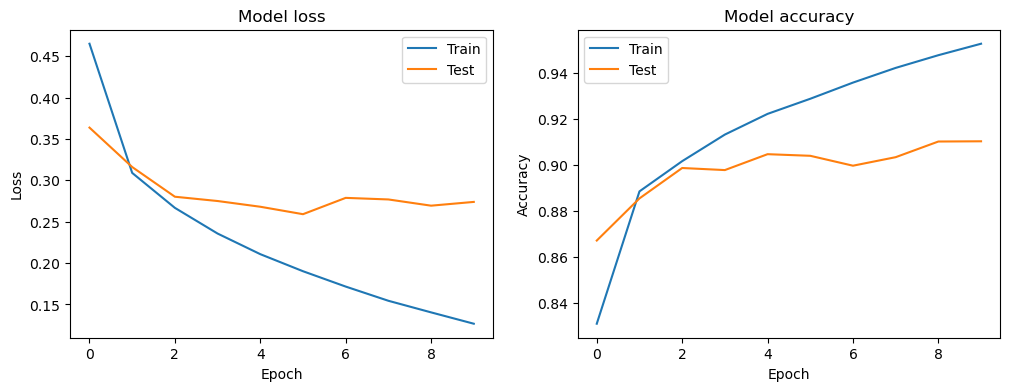

In [8]:
# Graficar pérdida y precisión en el entrenamiento
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12,4))

    # Crear gráfico de pérdida
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')

    # Crear gráfico de precisión
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Mostrar gráficos
    plt.show()

# Llamar a la función con nuestro objeto history
plot_history(history)

In [9]:
# Hacemos predicciones con el modelo

predictions = model.predict(test_images)

313/313 [==============================] - 1s 3ms/step


In [10]:
# Mostramos las primeras 5 predicciones

predictions[:5]

array([[7.98616659e-11, 4.90341838e-12, 1.32576511e-11, 4.53765003e-14,
        8.27197794e-13, 2.69378422e-08, 2.88063302e-14, 3.98725518e-07,
        8.11505974e-10, 9.99999523e-01],
       [1.16289607e-06, 5.53061794e-14, 9.99998569e-01, 3.58889052e-13,
        5.38483320e-08, 1.15780748e-16, 2.57335699e-07, 8.38619797e-19,
        2.04265722e-14, 1.11738006e-16],
       [2.37942466e-09, 1.00000000e+00, 2.54384291e-11, 3.20122027e-08,
        1.66691801e-12, 3.89516637e-17, 8.05018829e-11, 1.32839151e-17,
        1.49275738e-08, 1.03773474e-16],
       [2.23687631e-11, 9.99999881e-01, 4.72877727e-12, 7.49961870e-08,
        8.78649063e-12, 2.87388115e-16, 1.38154077e-09, 9.75385488e-18,
        9.59079821e-13, 1.80030186e-17],
       [9.48860347e-02, 1.76711126e-08, 4.32249904e-03, 2.39873880e-05,
        1.99776283e-03, 7.00135905e-09, 8.98769617e-01, 1.12184512e-10,
        5.70753930e-11, 3.06472292e-09]], dtype=float32)

In [11]:
# Mostramos las etiquetas reales de las primeras 5 imágenes

test_labels[:5]

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)>

In [12]:
# Mostramos las primeras 5 imágenes

test_images[:5]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

    

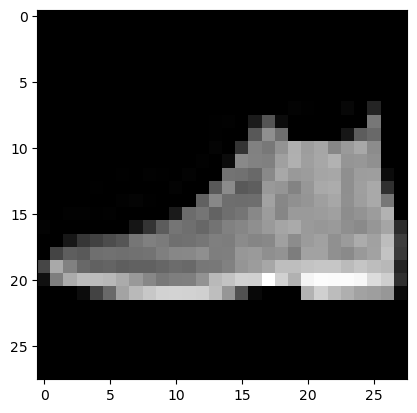

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)



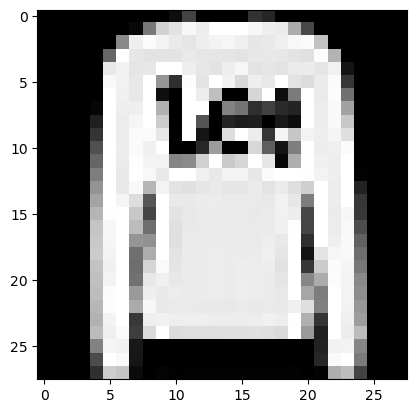

tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)



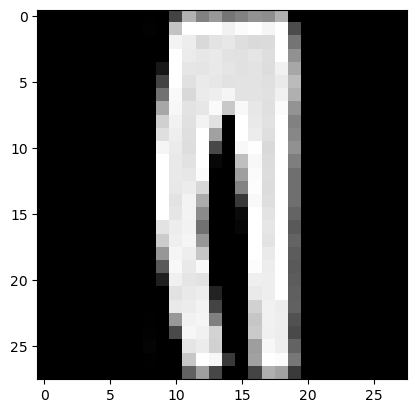

tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)



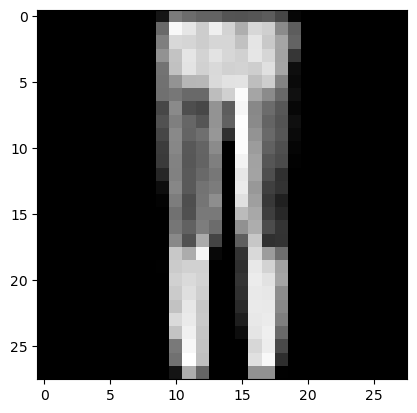

tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)



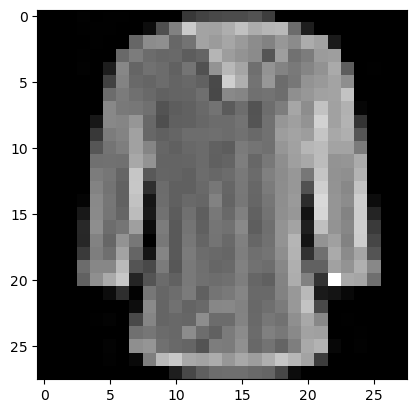

tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)



In [15]:
# Vamos a ver las imagenes reales

for i in range(0,5):
    first_image = test_images[i]
    first_image = np.array(first_image, dtype='float')
    pixels = first_image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()
    print(test_labels[i])
    print()